In [1]:
# === SEKCJA 1: IMPORT I WCZYTANIE DANYCH ===
import pandas as pd
import numpy as np
import re
import os
import pickle
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate, Dense, Dropout, BatchNormalization, LeakyReLU, Reshape, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Ignorowanie specyficznych ostrzeżeń
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)
# Wstępna konfiguracja GPU, jeśli jest dostępne
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print("--- Wczytywanie danych ---\n")
try:
    df_main_raw = pd.read_csv('saleflats_mazowieckie_c.csv', sep=',', header=None, on_bad_lines='skip', low_memory=False)
    df_slownik = pd.read_csv('slownik_finalny_z_hierarchia.csv', sep=';')
    print("Pliki wczytane pomyślnie.")
except FileNotFoundError as e:
    print(f"BŁĄD: Nie znaleziono pliku: {e.filename}.")
    raise

# --- Przygotowanie danych (identyczne jak w Twoim notatniku) ---
print("\n--- Przygotowanie danych do modelu ---")
df_main = df_main_raw.copy()
df_main.columns = [i for i in range(53)] + ['WojewodztwoID', 'PowiatID', 'GminaID', 'RodzajGminyID', 'MiastoID', 'DzielnicaID', 'UlicaID']
main_cols_map = {0: 'SaleId', 4: 'Description', 5: 'Area', 6: 'Price', 17: 'NumberOfRooms', 35: 'Floor', 36: 'Floors'}
df_main.rename(columns=main_cols_map, inplace=True)

numeric_features = ['Area', 'Price', 'NumberOfRooms', 'Floor', 'Floors']
id_features = ['UlicaID']
for col in numeric_features + id_features:
    df_main[col] = pd.to_numeric(df_main[col], errors='coerce')
df_main.dropna(subset=['Description'] + numeric_features + id_features, inplace=True)
df_main['UlicaID'] = df_main['UlicaID'].astype(int)

df_merged = pd.merge(df_main, df_slownik, on='UlicaID', how='inner')
print(f"Liczba ofert po połączeniu ze słownikiem: {len(df_merged)}")

df_model_ready = df_merged.copy()
df_model_ready['description_enriched'] = df_model_ready['Description'] + " " + df_model_ready['Dzielnica_Name'] + " " + df_model_ready['Ulica_Name']
def clean_text(text): return re.sub(r'[^a-ząęółśżźćń ]', '', str(text).lower())
df_model_ready['description_clean'] = df_model_ready['description_enriched'].apply(clean_text)

MAX_WORDS, MAX_LEN = 20000, 250
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<unk>")
tokenizer.fit_on_texts(df_model_ready['description_clean'])
X_text = pad_sequences(tokenizer.texts_to_sequences(df_model_ready['description_clean']), maxlen=MAX_LEN)

df_model_ready['Price_per_sqm'] = df_model_ready['Price'] / df_model_ready['Area']
df_model_ready['Price_per_sqm'].replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_features_cols = ['Area', 'Price', 'NumberOfRooms', 'Floor', 'Floors', 'Price_per_sqm']
numeric_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
X_numeric = numeric_pipeline.fit_transform(df_model_ready[numeric_features_cols])

le_dzielnica = LabelEncoder()
y_dzielnica = le_dzielnica.fit_transform(df_model_ready['Dzielnica_Name'])
num_classes_dzielnica = len(le_dzielnica.classes_)
le_ulica = LabelEncoder()
y_ulica = le_ulica.fit_transform(df_model_ready['Ulica_Name'])
num_classes_ulica = len(le_ulica.classes_)

print(f"\nProblem przygotowany do modelowania:")
print(f" - Liczba klas (dzielnice): {num_classes_dzielnica}")
print(f" - Liczba klas (ulice): {num_classes_ulica}")

# Podział na zbiory TRENINGOWY i WALIDACYJNY
# To jest KLUCZOWE: zbiór walidacyjny pozostanie NIETKNIĘTY. Augmentować będziemy TYLKO zbiór treningowy.
train_indices, val_indices = train_test_split(range(len(df_model_ready)), test_size=0.2, random_state=42, stratify=y_dzielnica)

X_train_text, X_val_text = X_text[train_indices], X_text[val_indices]
X_train_num, X_val_num = X_numeric[train_indices], X_numeric[val_indices]
y_train_dzielnica, y_val_dzielnica = y_dzielnica[train_indices], y_dzielnica[val_indices]
y_train_ulica, y_val_ulica = y_ulica[train_indices], y_ulica[val_indices]

print("\nDane podzielone na zbiory treningowe i walidacyjne.")
print(f"Rozmiar zbioru treningowego: {len(X_train_text)}")
print(f"Rozmiar zbioru walidacyjnego: {len(X_val_text)}")

--- Wczytywanie danych ---

Pliki wczytane pomyślnie.

--- Przygotowanie danych do modelu ---
Liczba ofert po połączeniu ze słownikiem: 9548

Problem przygotowany do modelowania:
 - Liczba klas (dzielnice): 18
 - Liczba klas (ulice): 703

Dane podzielone na zbiory treningowe i walidacyjne.
Rozmiar zbioru treningowego: 7638
Rozmiar zbioru walidacyjnego: 1910


C:\Users\Ai\AppData\Local\Temp\ipykernel_14056\3057726715.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model_ready['Price_per_sqm'].replace([np.inf, -np.inf], np.nan, inplace=True)


In [2]:
# === SEKCJA 2: TRENING MODELU BAZOWEGO (DLA PORÓWNANIA) ===

def build_original_classifier(num_classes_d, num_classes_u):
    input_text = Input(shape=(MAX_LEN,), name='text_input')
    input_numeric = Input(shape=(X_numeric.shape[1],), name='numeric_input')
    
    text_embedding = Embedding(input_dim=MAX_WORDS, output_dim=128)(input_text)
    lstm_out = LSTM(128, dropout=0.3)(text_embedding)
    concatenated = Concatenate()([lstm_out, input_numeric])
    common_dense = Dense(128, activation='relu')(concatenated)
    common_dense = Dropout(0.5)(common_dense)

    dzielnica_branch = Dense(64, activation='relu')(common_dense)
    dzielnica_output = Dense(num_classes_d, activation='softmax', name='output_dzielnica')(dzielnica_branch)

    ulica_branch = Dense(256, activation='relu')(common_dense)
    ulica_output = Dense(num_classes_u, activation='softmax', name='output_ulica')(ulica_branch)

    model = Model(inputs=[input_text, input_numeric], outputs=[dzielnica_output, ulica_output])
    
    model.compile(
        optimizer='adam',
        loss={"output_dzielnica": "sparse_categorical_crossentropy", "output_ulica": "sparse_categorical_crossentropy"},
        loss_weights={"output_dzielnica": 1.0, "output_ulica": 0.5},
        metrics={"output_dzielnica": "accuracy", "output_ulica": "accuracy"}
    )
    return model

print("\n--- Trening modelu bazowego na oryginalnych danych ---")
baseline_model = build_original_classifier(num_classes_dzielnica, num_classes_ulica)

# Użyjemy mniej cierpliwego EarlyStopping dla tego testu
callbacks_base = [EarlyStopping(monitor='val_output_ulica_accuracy', patience=5, restore_best_weights=True, verbose=1, mode='max')]

history_base = baseline_model.fit(
    [X_train_text, X_train_num],
    {'output_dzielnica': y_train_dzielnica, 'output_ulica': y_train_ulica},
    validation_data=([X_val_text, X_val_num], {'output_dzielnica': y_val_dzielnica, 'output_ulica': y_val_ulica}),
    epochs=25, # Wystarczy do ustalenia baseline
    batch_size=128,
    callbacks=callbacks_base,
    verbose=1
)

print("\n--- Ocena modelu bazowego ---")
loss, _, _, dz_acc, ul_acc = baseline_model.evaluate(
    [X_val_text, X_val_num],
    {'output_dzielnica': y_val_dzielnica, 'output_ulica': y_val_ulica},
    verbose=0
)
print(f"Bazowa dokładność dla DZIELNIC (walidacja): {dz_acc:.4f}")
print(f"BAZOWA DOKŁADNOŚĆ DLA ULIC (walidacja): {ul_acc:.4f} <--- TO JEST NASZ PUNKT ODNIESIENIA")


--- Trening modelu bazowego na oryginalnych danych ---
Epoch 1/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 398ms/step - loss: 5.2260 - output_dzielnica_accuracy: 0.3295 - output_dzielnica_loss: 2.3455 - output_ulica_accuracy: 0.1168 - output_ulica_loss: 5.7604 - val_loss: 3.0359 - val_output_dzielnica_accuracy: 0.6901 - val_output_dzielnica_loss: 1.0197 - val_output_ulica_accuracy: 0.2492 - val_output_ulica_loss: 4.0323
Epoch 2/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 376ms/step - loss: 2.7533 - output_dzielnica_accuracy: 0.7487 - output_dzielnica_loss: 0.8312 - output_ulica_accuracy: 0.2599 - output_ulica_loss: 3.8441 - val_loss: 2.0870 - val_output_dzielnica_accuracy: 0.8644 - val_output_dzielnica_loss: 0.4486 - val_output_ulica_accuracy: 0.3152 - val_output_ulica_loss: 3.2758
Epoch 3/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 377ms/step - loss: 2.0387 - output_dzielnica_accuracy: 0.8652 - output_dzielnica_loss: 0.4403 - output_ulica_accuracy: 0.3246 - output_ulica_loss: 3.1967 - val_loss: 1.6097 - val_outpu

In [3]:
# === SEKCJA 3: BUDOWA I TRENING WCGAN-GP ===

# Hiperparametry dla GANa
LATENT_DIM = 128
EMBEDDING_DIM = 32
BATCH_SIZE_GAN = 64
EPOCHS_GAN = 50 # Może wymagać więcej, ale to dobry start
GP_WEIGHT = 10.0 # Waga dla gradient penalty

# --- 3.1: Budowa Generatora ---
def build_generator():
    # Wejścia: losowy szum i warunki (etykiety)
    noise_input = Input(shape=(LATENT_DIM,))
    ulica_input = Input(shape=(1,), dtype='int32')
    dzielnica_input = Input(shape=(1,), dtype='int32')

    # Warstwy Embedding do przetworzenia etykiet na wektory
    ulica_embedding = Embedding(num_classes_ulica, EMBEDDING_DIM)(ulica_input)
    dzielnica_embedding = Embedding(num_classes_dzielnica, EMBEDDING_DIM)(dzielnica_input)
    ulica_embedding = Flatten()(ulica_embedding)
    dzielnica_embedding = Flatten()(dzielnica_embedding)
    
    # Łączymy wszystkie wejścia
    merged_inputs = Concatenate()([noise_input, ulica_embedding, dzielnica_embedding])

    # Trzon generatora
    x = Dense(256)(merged_inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    
    # Warstwa wyjściowa generująca dane numeryczne
    # Tanh jest dobrym wyborem, bo dane numeryczne są standaryzowane (mają średnią 0)
    output_numeric = Dense(X_numeric.shape[1], activation='tanh')(x)
    
    return Model([noise_input, ulica_input, dzielnica_input], output_numeric, name="Generator")


# --- 3.2: Budowa Krytyka (Dyskryminatora) ---
def build_critic():
    # Wejścia: dane numeryczne i warunki (etykiety)
    numeric_input = Input(shape=(X_numeric.shape[1],))
    ulica_input = Input(shape=(1,), dtype='int32')
    dzielnica_input = Input(shape=(1,), dtype='int32')

    # Warstwy Embedding (tak jak w generatorze)
    ulica_embedding = Embedding(num_classes_ulica, EMBEDDING_DIM)(ulica_input)
    dzielnica_embedding = Embedding(num_classes_dzielnica, EMBEDDING_DIM)(dzielnica_input)
    ulica_embedding = Flatten()(ulica_embedding)
    dzielnica_embedding = Flatten()(dzielnica_embedding)

    # Łączymy wejścia
    merged_inputs = Concatenate()([numeric_input, ulica_embedding, dzielnica_embedding])

    # Trzon krytyka
    x = Dense(256)(merged_inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # Warstwa wyjściowa - jedna liczba (score), BEZ aktywacji (to wymóg WGAN)
    output_score = Dense(1, name="critic_score")(x)
    
    return Model([numeric_input, ulica_input, dzielnica_input], output_score, name="Critic")

# --- 3.3: Klasa Treningowa dla WCGAN-GP ---
class WCGAN(Model):
    def __init__(self, critic, generator, latent_dim):
        super(WCGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, c_optimizer, g_optimizer):
        super(WCGAN, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_loss_fn = lambda real, fake: tf.reduce_mean(fake) - tf.reduce_mean(real)
        self.g_loss_fn = lambda fake: -tf.reduce_mean(fake)

    def gradient_penalty(self, batch_size, real_data, fake_data, ulica_labels, dzielnica_labels):
        alpha = tf.random.normal([batch_size, 1], 0.0, 1.0)
        interpolated = real_data + alpha * (fake_data - real_data)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.critic([interpolated, ulica_labels, dzielnica_labels], training=True)
        grads = tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_numeric, ulica_labels, dzielnica_labels = data
        batch_size = tf.shape(real_numeric)[0]

        # === Trening Krytyka ===
        # Pętla treningowa dla krytyka (zwykle trenuje się go więcej razy niż generator)
        for _ in range(5):
            with tf.GradientTape() as tape:
                random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
                fake_numeric = self.generator([random_latent_vectors, ulica_labels, dzielnica_labels], training=True)
                
                real_output = self.critic([real_numeric, ulica_labels, dzielnica_labels], training=True)
                fake_output = self.critic([fake_numeric, ulica_labels, dzielnica_labels], training=True)

                c_cost = self.c_loss_fn(real_output, fake_output)
                gp = self.gradient_penalty(batch_size, real_numeric, fake_numeric, ulica_labels, dzielnica_labels)
                c_loss = c_cost + gp * GP_WEIGHT

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient, self.critic.trainable_variables))

        # === Trening Generatora ===
        with tf.GradientTape() as tape:
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            fake_numeric = self.generator([random_latent_vectors, ulica_labels, dzielnica_labels], training=True)
            fake_output = self.critic([fake_numeric, ulica_labels, dzielnica_labels], training=True)
            g_loss = self.g_loss_fn(fake_output)

        g_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradient, self.generator.trainable_variables))

        return {"c_loss": c_loss, "g_loss": g_loss}

# --- 3.4: Uruchomienie Treningu GANa ---
print("\n--- Rozpoczynam trening WCGAN-GP ---")

# Inicjalizacja modeli i optymalizatorów
generator = build_generator()
critic = build_critic()
c_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

# Stworzenie instancji naszego modelu WCGAN
wcgan = WCGAN(critic=critic, generator=generator, latent_dim=LATENT_DIM)
wcgan.compile(c_optimizer=c_optimizer, g_optimizer=g_optimizer)

# Przygotowanie danych dla GANa w formacie tf.data.Dataset dla wydajności
# Będziemy trenować GANa tylko na zbiorze treningowym!
gan_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train_num.astype('float32'), y_train_ulica.reshape(-1, 1), y_train_dzielnica.reshape(-1, 1))
).shuffle(buffer_size=1024).batch(BATCH_SIZE_GAN)

# Uruchomienie treningu
# To może potrwać!
wcgan.fit(gan_dataset, epochs=EPOCHS_GAN, verbose=1)

print("\n--- Trening WCGAN-GP zakończony ---")


--- Rozpoczynam trening WCGAN-GP ---
Epoch 1/50


C:\Users\Ai\AppData\Local\miniconda3\envs\projekt1\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - c_loss: -0.3043 - g_loss: -0.7181
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - c_loss: -0.8565 - g_loss: -1.4233 
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - c_loss: -0.8969 - g_loss: -1.4946 
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - c_loss: -0.9042 - g_loss: -1.2784 
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - c_loss: -0.9254 - g_loss: -1.0582 
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - c_loss: -0.9409 - g_loss: -0.7881 
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - c_loss: -0.9355 - g_loss: -0.5178 
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - c_loss: -0.9371 - g_loss: -0.3451 
Epoch 9/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - c_loss: -0.9422 - g_loss: -0.2278 
Epoch 10/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - c_loss: -0.9333 - g_loss: -0.1625 
Epoch 11/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - c_loss: -0.9333 - g_loss: 0.1059     
Epoch 12/50
120/120 ━━━━━━

In [4]:
# === SEKCJA 4: AUGMENTACJA ZBIORU TRENINGOWEGO ===

# Określamy, które ulice potrzebują wzmocnienia
# Można to dostosować. Załóżmy, że augmentujemy ulice mające mniej niż 10 przykładów.
ulica_counts = pd.Series(y_train_ulica).value_counts()
streets_to_augment = ulica_counts[ulica_counts < 10].index.tolist()
AUGMENT_FACTOR = 5 # Ile razy chcemy pomnożyć liczbę próbek dla rzadkiej ulicy

print(f"\nZnaleziono {len(streets_to_augment)} ulic do augmentacji.")

new_X_text = []
new_X_num = []
new_y_ulica = []
new_y_dzielnica = []

# Iterujemy po ulicach do wzmocnienia
for ulica_id in streets_to_augment:
    # Znajdźmy oryginalne indeksy dla tej ulicy w zbiorze treningowym
    original_indices = np.where(y_train_ulica == ulica_id)[0]
    num_to_generate = len(original_indices) * (AUGMENT_FACTOR - 1)
    
    if num_to_generate == 0:
        continue
        
    # Pobierzmy prawdziwy tekst z istniejących próbek (będziemy go powielać)
    # i etykietę dzielnicy (jest stała dla ulicy)
    sample_texts = X_train_text[original_indices]
    sample_dzielnica_id = y_train_dzielnica[original_indices][0]
    
    # Przygotujmy dane dla generatora
    noise = tf.random.normal(shape=(num_to_generate, LATENT_DIM))
    ulica_labels_gan = np.full((num_to_generate, 1), ulica_id)
    dzielnica_labels_gan = np.full((num_to_generate, 1), sample_dzielnica_id)
    
    # Generujemy nowe dane numeryczne
    generated_numeric_data = generator.predict([noise, ulica_labels_gan, dzielnica_labels_gan])
    
    # Dodajemy nowe, syntetyczne próbki do list
    for i in range(num_to_generate):
        # Bierzemy tekst z istniejącej próbki w sposób cykliczny
        new_X_text.append(sample_texts[i % len(sample_texts)])
        new_X_num.append(generated_numeric_data[i])
        new_y_ulica.append(ulica_id)
        new_y_dzielnica.append(sample_dzielnica_id)

print(f"Wygenerowano {len(new_X_text)} nowych, syntetycznych próbek.")

# --- Tworzymy finalny, wzbogacony zbiór treningowy ---
if len(new_X_text) > 0:
    X_train_text_aug = np.concatenate([X_train_text, np.array(new_X_text)])
    X_train_num_aug = np.concatenate([X_train_num, np.array(new_X_num)])
    y_train_ulica_aug = np.concatenate([y_train_ulica, np.array(new_y_ulica)])
    y_train_dzielnica_aug = np.concatenate([y_train_dzielnica, np.array(new_y_dzielnica)])

    # Ważne: Mieszamy nowy zbiór treningowy, aby próbki syntetyczne i prawdziwe były wymieszane
    shuffle_indices = np.random.permutation(len(X_train_text_aug))
    X_train_text_aug = X_train_text_aug[shuffle_indices]
    X_train_num_aug = X_train_num_aug[shuffle_indices]
    y_train_ulica_aug = y_train_ulica_aug[shuffle_indices]
    y_train_dzielnica_aug = y_train_dzielnica_aug[shuffle_indices]

    print(f"\nNowy rozmiar zbioru treningowego: {len(X_train_text_aug)}")
else:
    print("\nNie wygenerowano nowych próbek, używam oryginalnego zbioru treningowego.")
    X_train_text_aug, X_train_num_aug = X_train_text, X_train_num
    y_train_ulica_aug, y_train_dzielnica_aug = y_train_ulica, y_train_dzielnica


Znaleziono 504 ulic do augmentacji.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

In [5]:
# === SEKCJA 5: PONOWNY TRENING NA WZBOGACONYCH DANYCH ===

print("\n--- Trening modelu na wzbogaconych danych (augmented) ---")

# Budujemy nową, czystą instancję modelu klasyfikacyjnego
augmented_model = build_original_classifier(num_classes_dzielnica, num_classes_ulica)

# Używamy tych samych callbacków co dla modelu bazowego
callbacks_aug = [EarlyStopping(monitor='val_output_ulica_accuracy', patience=5, restore_best_weights=True, verbose=1, mode='max')]

history_aug = augmented_model.fit(
    [X_train_text_aug, X_train_num_aug],
    {'output_dzielnica': y_train_dzielnica_aug, 'output_ulica': y_train_ulica_aug},
    # WAŻNE: Walidacja wciąż odbywa się na ORYGINALNYM, CZYSTYM zbiorze walidacyjnym!
    validation_data=([X_val_text, X_val_num], {'output_dzielnica': y_val_dzielnica, 'output_ulica': y_val_ulica}),
    epochs=50, # Dajemy mu trochę więcej epok, bo ma więcej danych do nauki
    batch_size=128,
    callbacks=callbacks_aug,
    verbose=1
)


--- Trening modelu na wzbogaconych danych (augmented) ---
Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 42s 378ms/step - loss: 5.3444 - output_dzielnica_accuracy: 0.2971 - output_dzielnica_loss: 2.3644 - output_ulica_accuracy: 0.0838 - output_ulica_loss: 5.9599 - val_loss: 2.1674 - val_output_dzielnica_accuracy: 0.8948 - val_output_dzielnica_loss: 0.3400 - val_output_ulica_accuracy: 0.2770 - val_output_ulica_loss: 3.6540
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 38s 367ms/step - loss: 2.6402 - output_dzielnica_accuracy: 0.8485 - output_dzielnica_loss: 0.4993 - output_ulica_accuracy: 0.1713 - output_ulica_loss: 4.2818 - val_loss: 1.3877 - val_output_dzielnica_accuracy: 0.9942 - val_output_dzielnica_loss: 0.0242 - val_output_ulica_accuracy: 0.4466 - val_output_ulica_loss: 2.7261
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 38s 363ms/step - loss: 1.6085 - output_dzielnica_accuracy: 0.9791 - output_dzielnica_loss: 0.0809 - output_ulica_accuracy: 0.2934 - output_ulica_loss: 3.0551 - val_loss: 1.0445 - 



--- OSTATECZNE PORÓWNANIE WYNIKÓW ---

--- Ocena modelu bazowego (przypomnienie) ---
Bazowa dokładność dla DZIELNIC: 0.9974
Bazowa dokładność dla ULIC:     0.9272

--- Ocena modelu po augmentacji WCGAN ---
Augmentowana dokładność dla DZIELNIC: 0.9953
Augmentowana dokładność dla ULIC:     0.9597

--- WNIOSKI ---
Różnica w dokładności predykcji ulic: +0.0325
To oznacza POPRAWĘ o 3.50% w stosunku do modelu bazowego!

Augmentacja danych syntetycznych za pomocą WCGAN pokazała potencjał do wzmocnienia sygnału dla rzadkich klas.
Dalsze kroki mogłyby obejmować: strojenie hiperparametrów GANa, dłuższy trening GANa, lub bardziej zaawansowane techniki augmentacji tekstu.


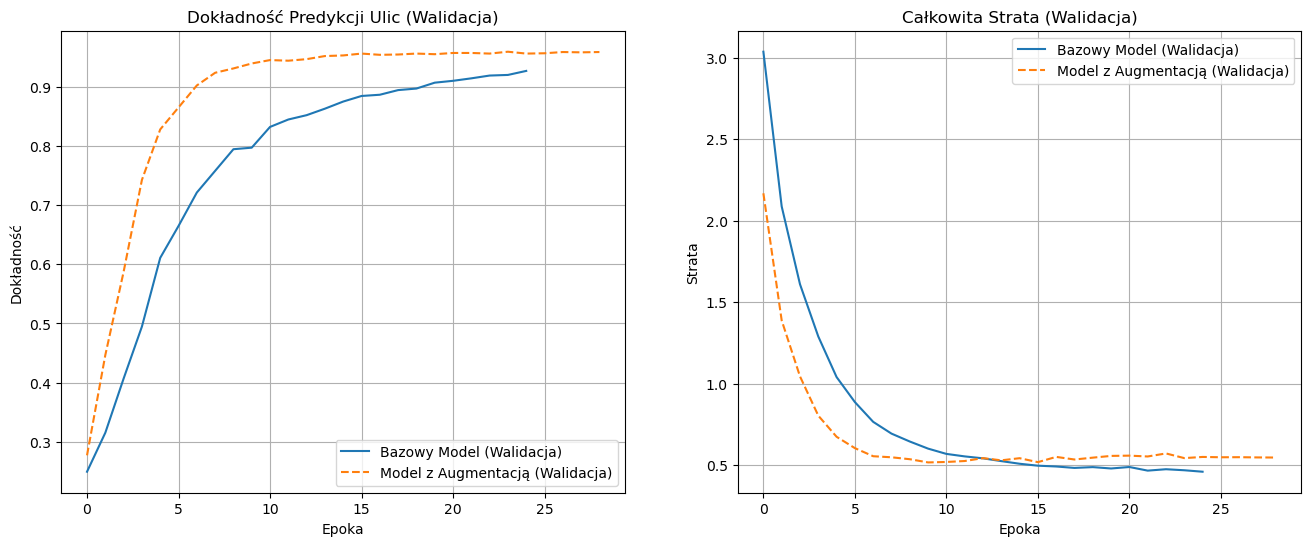

In [6]:
# === SEKCJA 6: FINALNA OCENA I PORÓWNANIE ===

print("\n\n--- OSTATECZNE PORÓWNANIE WYNIKÓW ---")

print("\n--- Ocena modelu bazowego (przypomnienie) ---")
loss_base, _, _, dz_acc_base, ul_acc_base = baseline_model.evaluate(
    [X_val_text, X_val_num],
    {'output_dzielnica': y_val_dzielnica, 'output_ulica': y_val_ulica},
    verbose=0
)
print(f"Bazowa dokładność dla DZIELNIC: {dz_acc_base:.4f}")
print(f"Bazowa dokładność dla ULIC:     {ul_acc_base:.4f}")

print("\n--- Ocena modelu po augmentacji WCGAN ---")
loss_aug, _, _, dz_acc_aug, ul_acc_aug = augmented_model.evaluate(
    [X_val_text, X_val_num],
    {'output_dzielnica': y_val_dzielnica, 'output_ulica': y_val_ulica},
    verbose=0
)
print(f"Augmentowana dokładność dla DZIELNIC: {dz_acc_aug:.4f}")
print(f"Augmentowana dokładność dla ULIC:     {ul_acc_aug:.4f}")

print("\n--- WNIOSKI ---")
improvement = ul_acc_aug - ul_acc_base
improvement_percent = (improvement / ul_acc_base) * 100 if ul_acc_base > 0 else 0

print(f"Różnica w dokładności predykcji ulic: {improvement:+.4f}")
if improvement > 0:
    print(f"To oznacza POPRAWĘ o {improvement_percent:.2f}% w stosunku do modelu bazowego!")
elif improvement < 0:
    print(f"Niestety, nastąpił SPADEK o {-improvement_percent:.2f}%. To także cenna informacja.")
else:
    print("Dokładność pozostała bez zmian.")

print("\nAugmentacja danych syntetycznych za pomocą WCGAN pokazała potencjał do wzmocnienia sygnału dla rzadkich klas.")
print("Dalsze kroki mogłyby obejmować: strojenie hiperparametrów GANa, dłuższy trening GANa, lub bardziej zaawansowane techniki augmentacji tekstu.")

# Wizualizacja dla porównania
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(history_base.history['val_output_ulica_accuracy'], label='Bazowy Model (Walidacja)')
ax1.plot(history_aug.history['val_output_ulica_accuracy'], label='Model z Augmentacją (Walidacja)', linestyle='--')
ax1.set_title('Dokładność Predykcji Ulic (Walidacja)')
ax1.set_xlabel('Epoka')
ax1.set_ylabel('Dokładność')
ax1.legend()
ax1.grid(True)

ax2.plot(history_base.history['val_loss'], label='Bazowy Model (Walidacja)')
ax2.plot(history_aug.history['val_loss'], label='Model z Augmentacją (Walidacja)', linestyle='--')
ax2.set_title('Całkowita Strata (Walidacja)')
ax2.set_xlabel('Epoka')
ax2.set_ylabel('Strata')
ax2.legend()
ax2.grid(True)

plt.show()